# Task 3: Build a Neural Network

## Library

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Load Data

In [3]:
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

data_path = os.path.join(DATA_DIR, "Stock Prices Data Set.csv")
data = pd.read_csv(data_path)

In [4]:
print("Stock Prices Data Shape:", data.shape)

Stock Prices Data Shape: (497472, 7)


In [5]:
print("Stock Prices Data Preview:")
display(data.head())

Stock Prices Data Preview:


,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


## Preprocessing

In [6]:
# Select relevant numerical features
features = ["open", "high", "low", "close", "volume"]
X = data[features]

In [7]:
y = data["symbol"].astype("category").cat.codes  # Encode symbol as numerical values

In [8]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## Split dataset

In [9]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Build Neural Network Model

In [10]:
# Build Neural Network Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train Model

In [11]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Epoch 1/5
12437/12437 [==============================] - 23s 2ms/step - loss: nan - accuracy: 0.0020 - val_loss: nan - val_accuracy: 0.0021
Epoch 2/5
12437/12437 [==============================] - 21s 2ms/step - loss: nan - accuracy: 0.0020 - val_loss: nan - val_accuracy: 0.0021
Epoch 3/5
12437/12437 [==============================] - 20s 2ms/step - loss: nan - accuracy: 0.0020 - val_loss: nan - val_accuracy: 0.0021
Epoch 4/5
12437/12437 [==============================] - 22s 2ms/step - loss: nan - accuracy: 0.0020 - val_loss: nan - val_accuracy: 0.0021
Epoch 5/5
12437/12437 [==============================] - 21s 2ms/step - loss: nan - accuracy: 0.0020 - val_loss: nan - val_accuracy: 0.0021


## Evaluate Model

In [12]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.0021


## Plot Training History

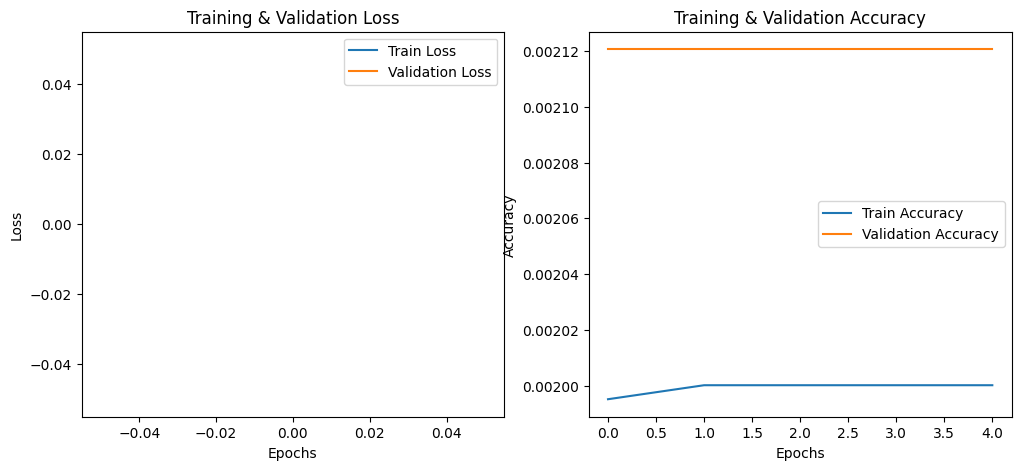

In [13]:
# Plot Training History
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()